# Detect Aircraft in Satellite Imagery
## Stage 1: Data Import and EDA


### Data Import

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import collections
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline
sns.set_style('white')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['grid.color'] = 'k'

In [9]:
with open('./planesnet/planesnet.json', mode='r') as file:
    planesdict = json.load(file)
df = pd.DataFrame(planesdict)
df.head()

,data,labels,locations,scene_ids
0,"[206, 195, 187, 183, 177, 175, 174, 193, 198, ...",1,"[-118.40497658522878, 33.940618514147936]",20170620_175442_0e30
1,"[215, 209, 200, 196, 192, 197, 205, 168, 155, ...",1,"[-122.392469714, 37.6176425378]",20161212_180859_0e30
2,"[204, 214, 220, 219, 213, 205, 198, 193, 199, ...",1,"[-122.397578597, 37.6209247852]",20170524_181349_0e2f
3,"[179, 174, 179, 178, 173, 170, 168, 168, 168, ...",1,"[-122.214849831, 37.7203378331]",20161110_180707_0e1f
4,"[222, 222, 218, 214, 208, 205, 207, 206, 206, ...",1,"[-117.862173435, 33.6796854072]",20160813_184932_0c64


New commercial satellite imagery providers are using constellations of small satellites to exponentially increase the amount of images of the earth captured every day. The purpose of this project is to detect the location of airplanes in satellite images collected over California. 

A total of 32000 images are provided, the images are 20x20 pixels in size, each with three bands (RGB), delivered in a JSON formatted file containing data, labels, scene id's, latitude, and longitude.

**The "plane" class includes 8000 images:**

1. The first group of 8000 images are near-centered on the body of a single airplane, with the majority of the plane's wings, tail, and nose visible. 

**The "not-plane" class includes 24000 images:**

2. The second group of 8000 images are a random sampling of different 'land-cover' features - water, vegetation, bare earth, buildings, etc. - that do not include any portion of an airplane. 


3. The third group of 8000 images are 'partial planes' that contain only a portion of an airplane. 


4. The fourth group of 8000 are 'confusers' - chips with bright objects or strong linear features that resemble a plane.

###  Map of Locations of Satellite Images in California 
*** 

A map is displayed to show the locations of the satellite images taken over California. These include all 'plane', and all 'not-plane'.

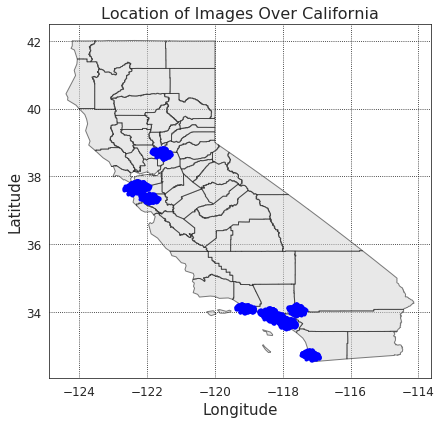

In [19]:
#list of Latitudes and Longitudes, import California shapefile
lons = [lon for lon, lat in planesdict['locations']]
lats = [lat for lon, lat in planesdict['locations']]
cali = gpd.read_file('/home/delloro/Springboard/Assignments/Capstone_2/maps/CA_counties/CA_counties.shp')

#plot location of images in California
fig, ax = plt.subplots(figsize=(7, 6))
fig = ax.plot(lons, lats, linestyle='none', marker='.', color='blue')
cali.plot(ax=ax, color='lightgray', alpha=0.5, edgecolor='k')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(b=True, which='both', axis='both', color='k', linestyle=':')
ax.set_title('Location of Images Over California', size=16)
plt.savefig('/home/delloro/Springboard/Assignments/Capstone_2/figures/Cali_map.png')
plt.tight_layout()
plt.show()

### Classification Scheme
***

75% of the 32000 images are classified as 'not-plane', the remaining 25% are classified as 'plane'.

The "plane" class includes 8000 images, and the "not-plane" class includes 24000 images. 

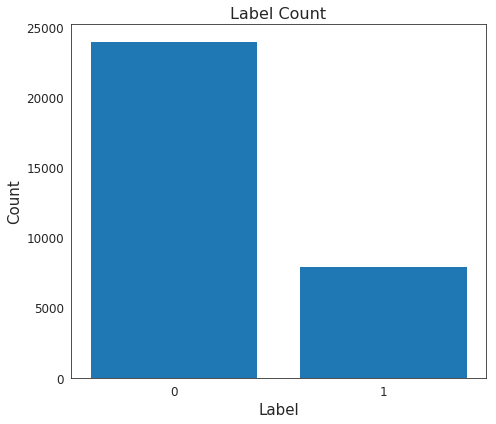

75% Not-Planes (0)
25% Planes (1)


In [4]:
#number of 'plane' and 'not-plane' images
label_count = collections.Counter(planesdict['labels'])
fig, ax = plt.subplots(figsize=(7, 6))
ax.bar(label_count.keys(), label_count.values())
ax.set_xticks(ticks=[0,1])
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_title('Label Count', size=16)
plt.savefig('/home/delloro/Springboard/Assignments/Capstone_2/figures/class_schm.png')
plt.tight_layout()
plt.show()

print('{}% Not-Planes (0)'.format(int(label_count[0]/32000 *100)))
print('{}% Planes (1)'.format(int(label_count[1]/32000 *100)))

### Sample Satellite Images
***

Twelve satellite images from the dataset are displayed below, three of class 'plane', and nine of class 'not-plane'.

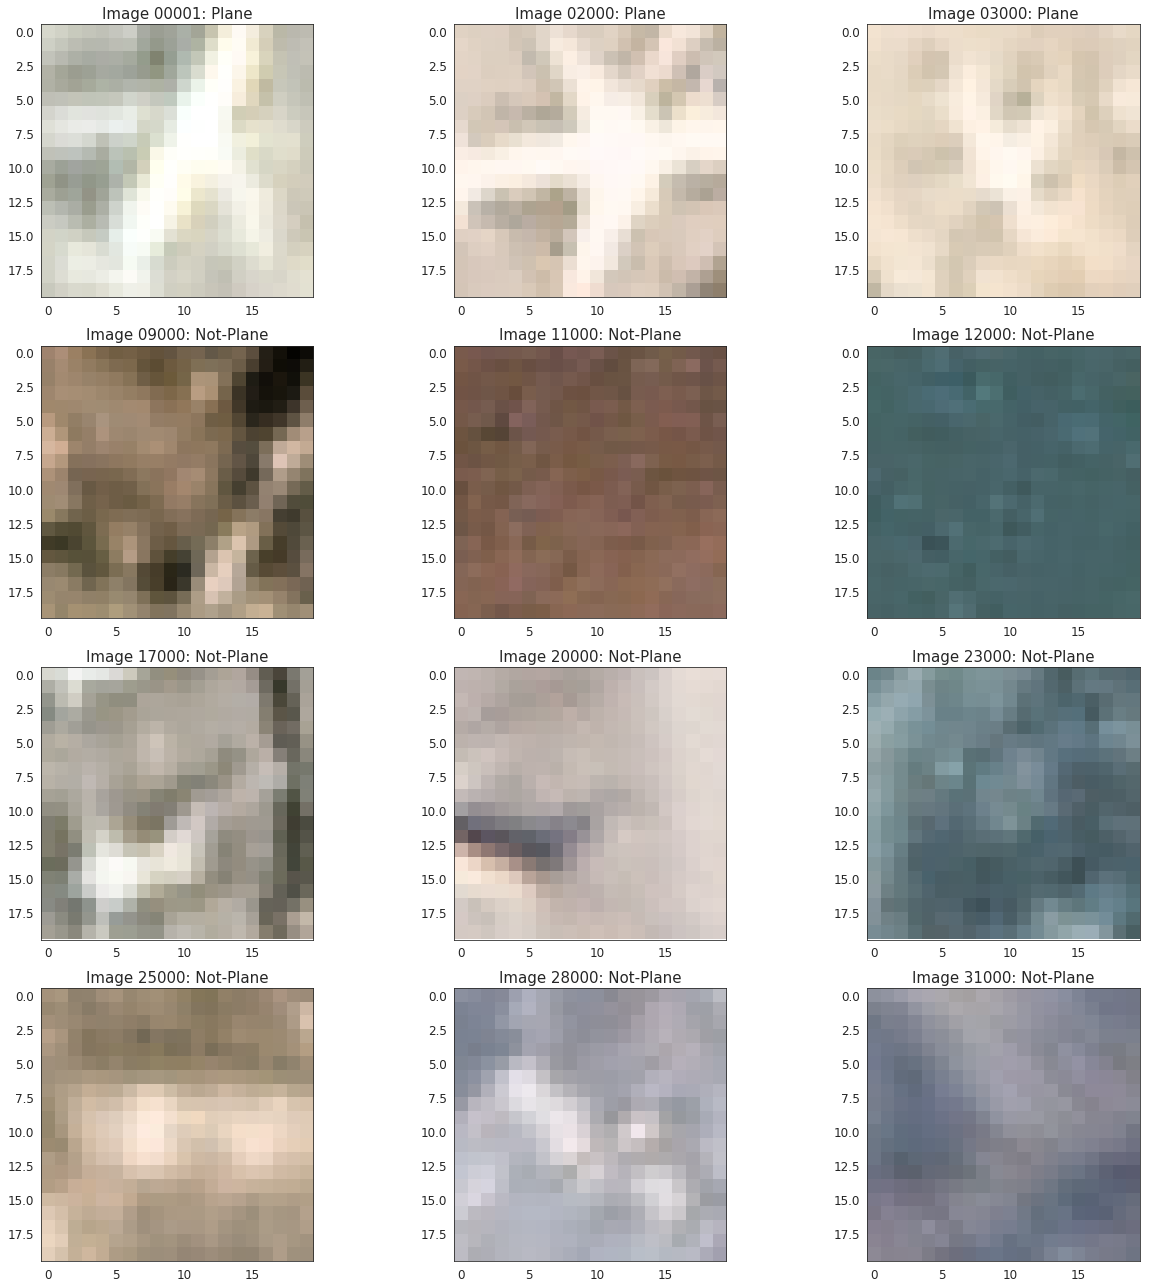

In [6]:
#satellite images of 'plane' and 'not-plane'
plt.figure(figsize=(18, 18))
for index, value in enumerate([1, 2000, 3000, 9000, 11000, 12000, 17000, 20000, 23000, 25000, 28000, 31000]):
    plt.subplot(4, 3, index+1)
    img = np.array(planesdict['data'][value]) 
    img = img.reshape((3, 400)).T.reshape((20,20,3))
    
    if planesdict['labels'][value] == 1:
        label = 'Plane'
    else:
        label = 'Not-Plane'
        
    plt.title('Image {:05d}: '.format(value) + label, size=15)
    plt.imshow(img)
plt.savefig('/home/delloro/Springboard/Assignments/Capstone_2/figures/exmp_imgs.png')
plt.tight_layout()    
plt.show()

### Root Mean Square (RMS) Display
***

RMS pixel intensity is calculated on each satellite image. RMS can be used to visually identify pixel intensity spikes and outliers, such as images with very high or very low pixel intensity.

From the display below, it appears that the 'land-cover' images have both the highest, and lowest RMS values within the dataset. It could be interpreted that the 'land-cover' images tend to have stronger reflectivity properties than other images in the dataset. This interpretation can be visually cross-checked by looking at the twelve images displayed above.

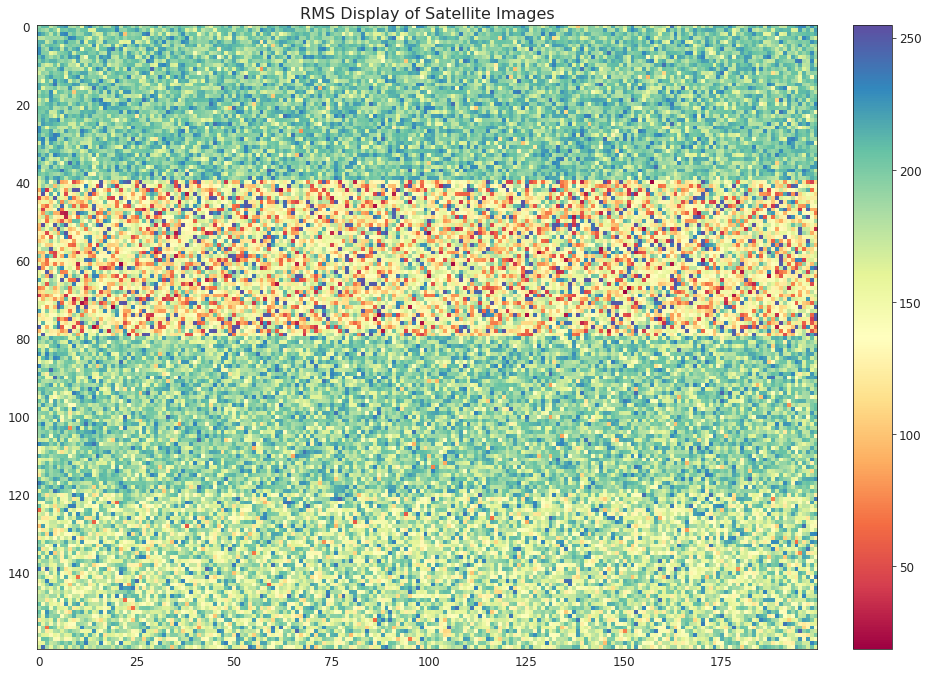

In [16]:
#calculate RMS with all pixels, for each satellite image
RMS_pixels = [np.sqrt(np.mean(np.array(img)**2)) for img in planesdict['data']]

#rows 0 to 40 are 'plane', 40 to 80 are 'land-cover', 80 to 120 are 'partial plane', 120 to 160 are 'confusers'
RMS_pixels = np.array(RMS_pixels).reshape((160, 200))

#plot RMS
plt.figure(figsize=(13, 13))
ax = plt.gca() #get the current axes instance on the current figure
img = plt.imshow(RMS_pixels, cmap='Spectral')
divider = make_axes_locatable(ax) #get axes divider for the axes image is plot in
cax = divider.append_axes("right", size="5%", pad=0.5) #create colorbar axes
ax.set_title('RMS Display of Satellite Images', fontsize=16)
plt.colorbar(img, cax=cax)
plt.savefig('/home/delloro/Springboard/Assignments/Capstone_2/figures/RMS.png')

plt.tight_layout()
plt.show()

### RGB Band Split
***
Red, green, and blue (RGB) bands or channels represent the primary colors of an image. These three bands in the satellite images are separated in order to visually inspect the pixel intensity of the bands from a few select satellite images. Based on visual inspection, it is difficult to determine whether the bands are well balanced, or if there is an overly dominant or weak band when comparing the band intensities of an individual image. However, it appears that there may be some variation in band intensity between the 'plane' and 'not-plane' classes.

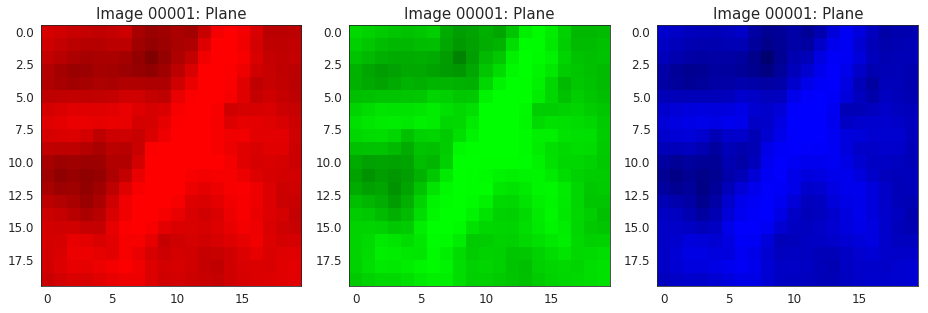

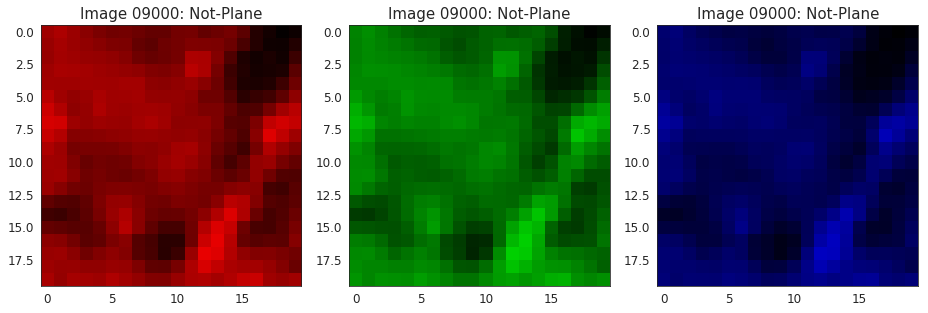

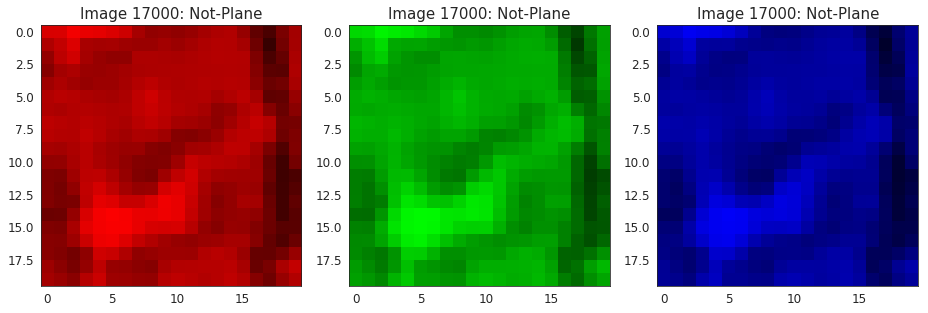

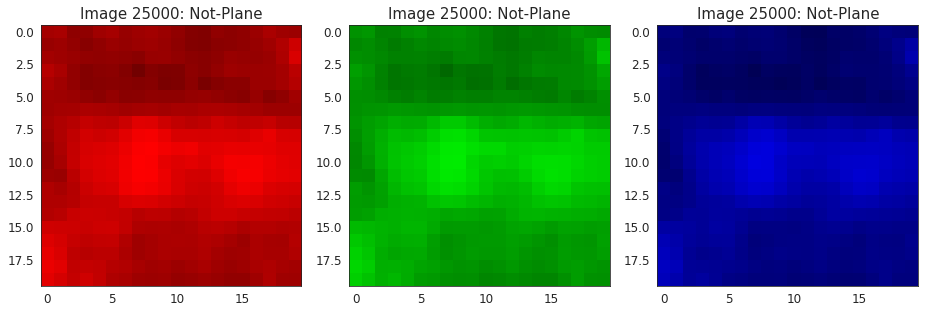

In [8]:
#RGB channels of 'plane' and 'not-plane'
for index in [1, 9000, 17000, 25000]:
    plt.figure(figsize=(13, 6))
    for n in range(1,4):
        plt.subplot(1, 3, n)
        img = np.array(planesdict['data'][index])
        img = img.reshape((3,400)).T.reshape((20,20,3))
        temp = np.zeros(img.shape)
        temp[:, :, n-1] = img[:, :, n-1] / 255
        
        if planesdict['labels'][index] == 1:
            label = 'Plane'
        else:
            label = 'Not-Plane'
        
        plt.title('Image {:05d}: '.format(index) + label, size=15)
        plt.imshow(temp)
    plt.savefig('/home/delloro/Springboard/Assignments/Capstone_2/figures/rgb_img_{}.png'.format(index))
    plt.tight_layout()
    plt.show()

### Grayscale Images and RGB Bands
***
The nine images from above are re-displayed in grayscale, along with pixel intensity distributions of the three bands provided in the dataset: red, green, and blue. 

There appears to be variation between the bands of 'plane' and 'not-plane' classes. From visual inspection, the 'plane' class bands tend to show flatter peaks, while the 'not-plane' class shows sharper peaks on each band.

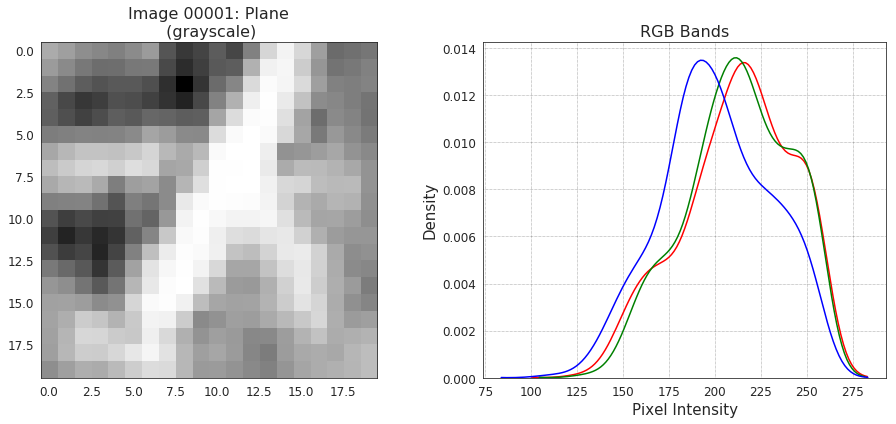

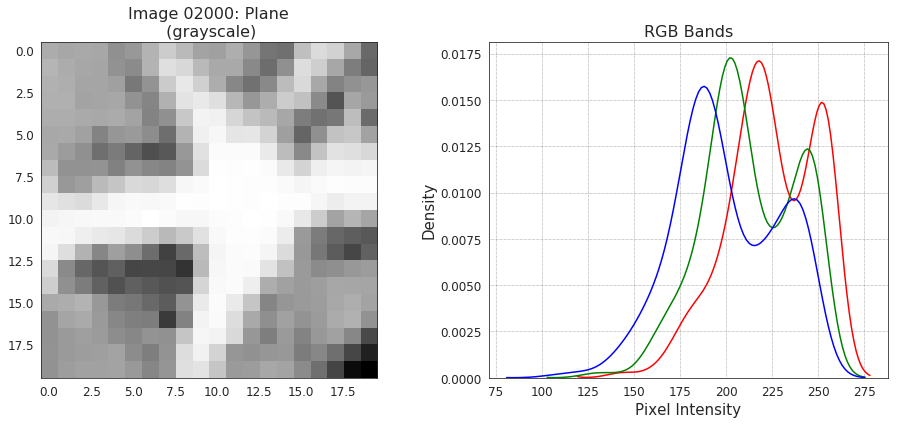

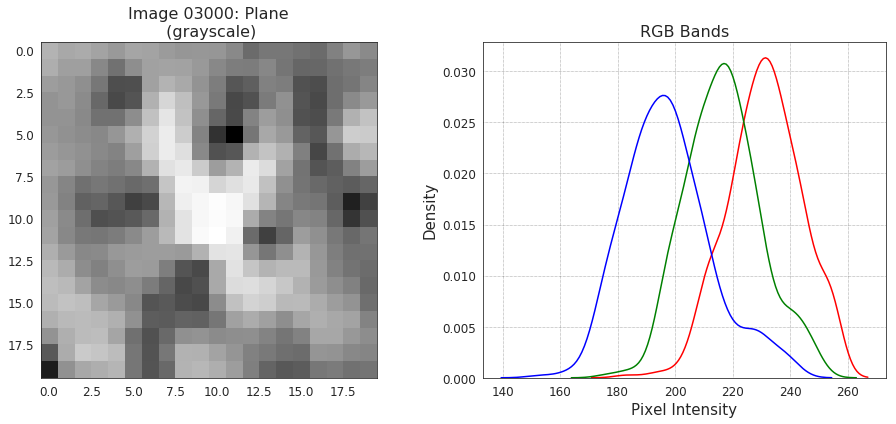

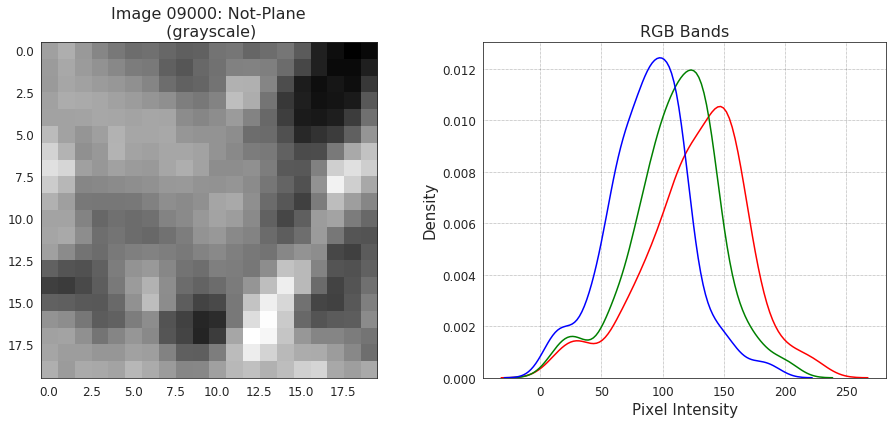

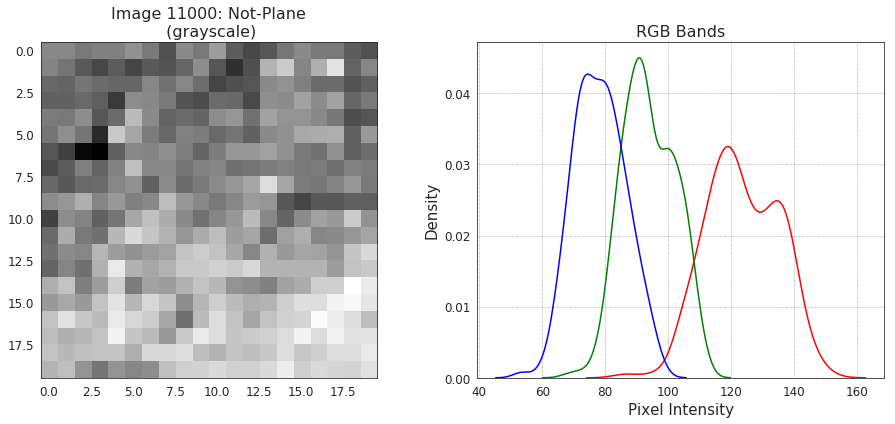

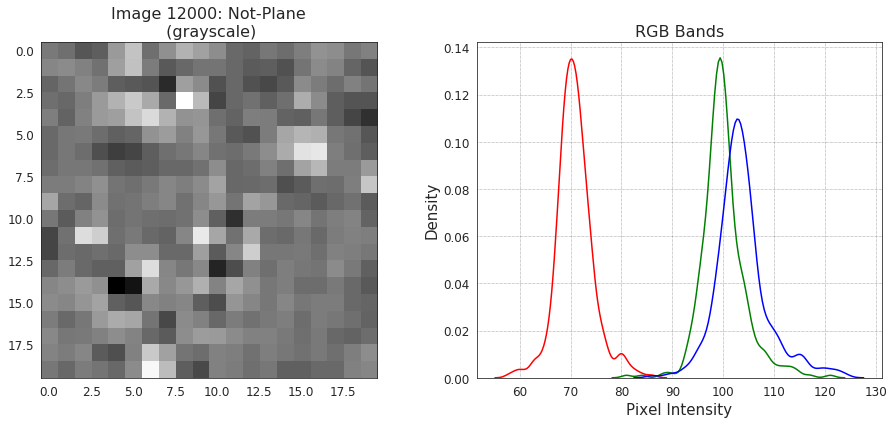

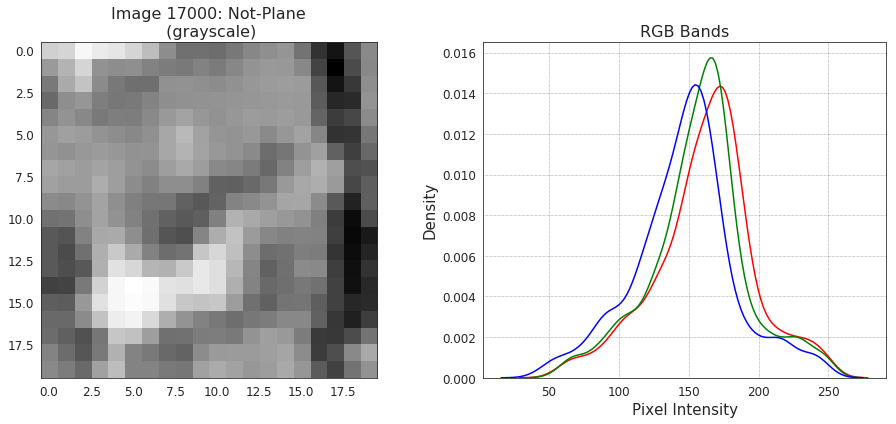

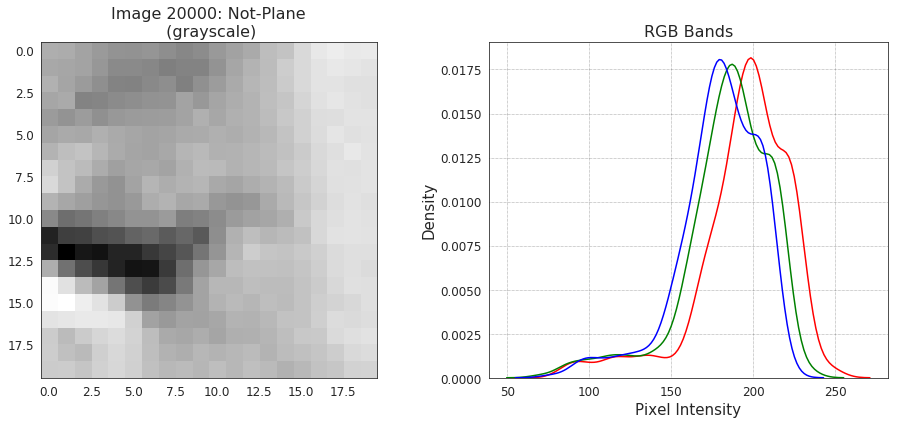

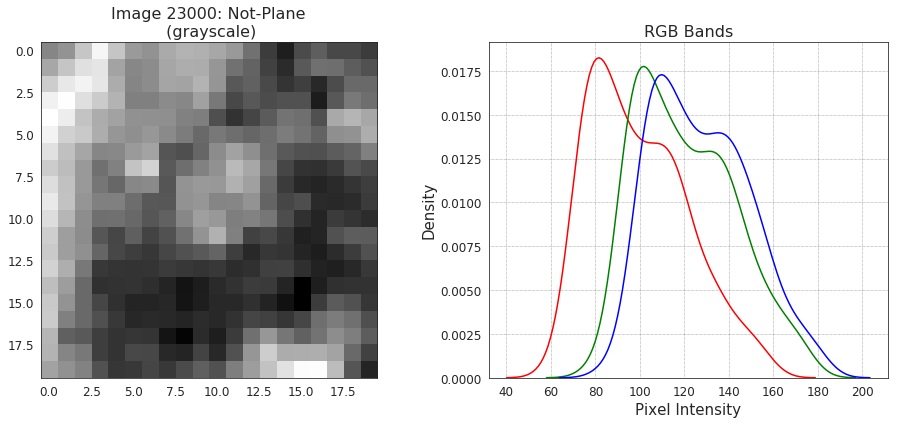

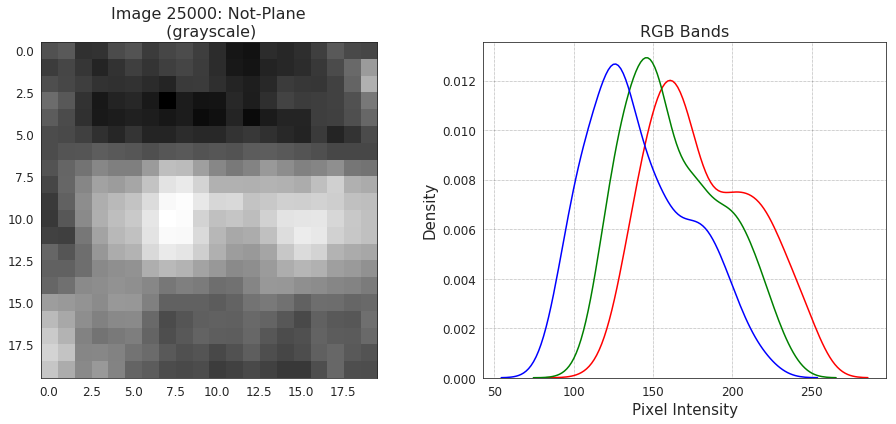

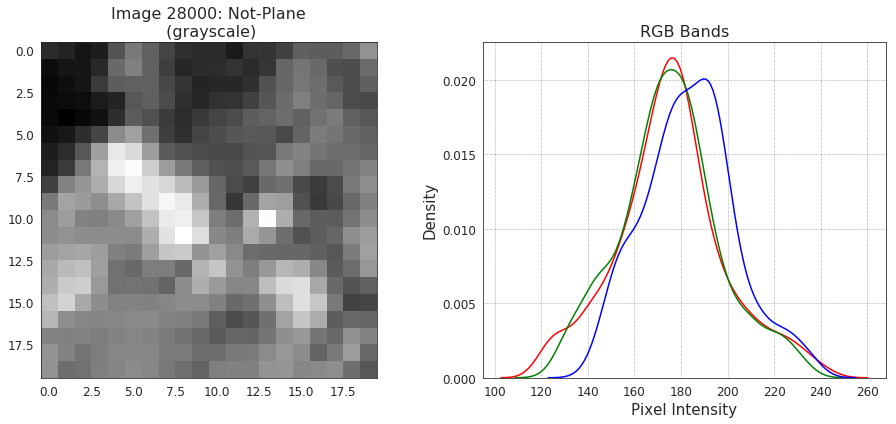

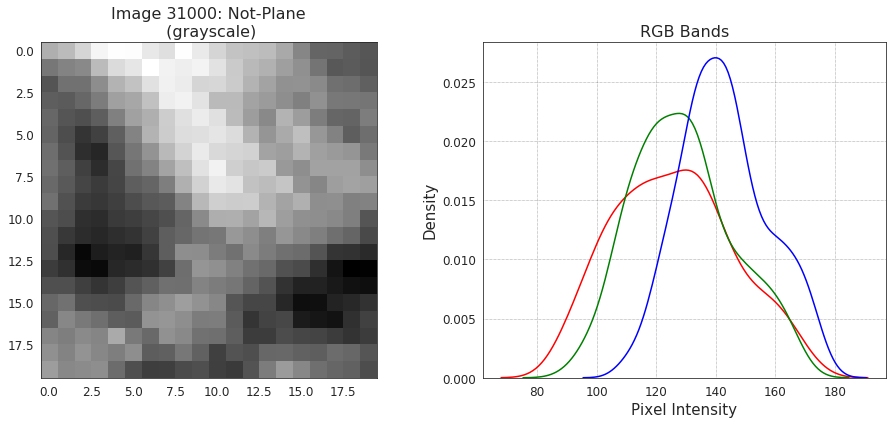

In [67]:
#gray-scale satellite images and RGB bands of 'plane' and 'not-plane'
for index in [1, 2000, 3000, 9000, 11000, 12000, 17000, 20000, 23000, 25000, 28000, 31000]:
    plt.figure(figsize=(13, 6))
    plt.subplot(1, 2, 1)
    img = np.array(planesdict['data'][index]) 
    img = img.reshape((3, 400)).T.reshape((20,20,3))
    img = np.sum(img, axis=2)
    if planesdict['labels'][index] == 1:
        label = 'Plane'
    else:
        label = 'Not-Plane'
    plt.title('Image {:05d}: '.format(index) +label + '\n (grayscale)', size=16)
    plt.imshow(img, cmap='gist_gray')
    
    plt.subplot(1, 2, 2)
    sns.kdeplot(planesdict['data'][index][0:400], color='red')
    sns.kdeplot(planesdict['data'][index][400:800], color='green')
    sns.kdeplot(planesdict['data'][index][800:1200], color='blue')
    plt.grid(color='k', linestyle=':', linewidth=0.5, alpha=0.7)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    plt.title('RGB Bands', size=16)
    plt.savefig('/home/delloro/Springboard/Assignments/Capstone_2/figures/grayscale{}.png'.format(index))
    plt.tight_layout()
    plt.show()


### RGB Bands of Plane and Not-Plane Classes
***
The aggregate distributions of red, green, and blue bands of 'plane' and 'not-plane' classes are plotted below. 

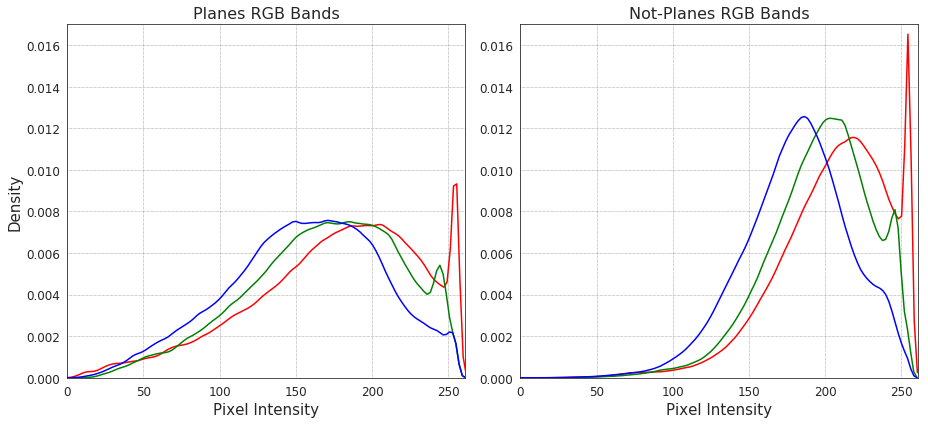

In [8]:
#pixel intensities for all 'plane' images (label 1)
reds_1 = []
greens_1 = []
blues_1 = []

for img in planesdict['data'][:8000]: #first 8000 images are planes (1)
    reds_1.append(img[0:400])
    greens_1.append(img[400:800])
    blues_1.append(img[800:1200])
    
reds_1 = [item for sublist in reds_1 for item in sublist]
greens_1 = [item for sublist in greens_1 for item in sublist]
blues_1 = [item for sublist in blues_1 for item in sublist]

#pixel intensities for all 'not-plane' images (label 0)
reds_0 = []
greens_0 = []
blues_0 = []

for img in planesdict['data'][8000:]: #last 24000 images are 'not-plane' (0)
    reds_0.append(img[0:400])
    greens_0.append(img[400:800])
    blues_0.append(img[800:1200])
    
reds_0 = [item for sublist in reds_0 for item in sublist]
greens_0 = [item for sublist in greens_0 for item in sublist]
blues_0 = [item for sublist in blues_0 for item in sublist]

#kde plots
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
sns.kdeplot(reds_0, color='red', ax=ax[0])
sns.kdeplot(greens_0, color='green', ax=ax[0])
sns.kdeplot(blues_0, color='blue', ax=ax[0])
sns.kdeplot(reds_1, color='red', ax=ax[1])
sns.kdeplot(greens_1, color='green', ax=ax[1])
sns.kdeplot(blues_1, color='blue', ax=ax[1])
ax[0].set_xlabel('Pixel Intensity')
ax[0].set_ylabel('Density')
ax[0].set_xlim(0, 261)
ax[0].set_ylim(0, 0.017)
ax[0].grid(color='k', linestyle=':', linewidth=0.5, alpha=0.7)
ax[0].set_title('Planes RGB Bands', size=16)
ax[1].set_xlabel('Pixel Intensity')
ax[1].set_ylabel('')
ax[1].set_xlim(0, 261)
ax[1].set_ylim(0, 0.017)
ax[1].set_title('Not-Planes RGB Bands', size=16)
ax[1].grid(color='k', linestyle=':', linewidth=0.5, alpha=0.7)
plt.savefig('/home/delloro/Springboard/Assignments/Capstone_2/figures/rgb_dists.png')
plt.tight_layout()
plt.show()

### Bootstrap Hypotheses Test for Statistical Significance

#### Test: All Bands
***
A hypothesis test is performed to determine whether there is a statistically significant difference in the mean pixel intensity between 'plane' and 'not-plane' classes. 

The null hypothesis is that there is no significant difference in the mean pixel intensity between 'plane' and 'not-plane' classes. 

The alternative hypothesis is that there is a significant difference between the two classes.

$H_0$:  $\mu_1$ - $\mu_2$ $=$ 0

$H_a$:  $\mu_1$ - $\mu_2$ $\neq$ 0 

$\alpha$ $=$ $0.05$

In [427]:
#define groups and means
planes_all_bands = reds_1 + greens_1 + blues_1
notplanes_all_bands = reds_0 + greens_0 + blues_0
total = planes_all_bands + notplanes_all_bands

mean_planes = np.mean(planes_all_bands)
mean_notplanes = np.mean(notplanes_all_bands)
mean_total = np.mean(total)

obs_diff = mean_planes - mean_notplanes

#shift the groups
planes_shifted = planes_all_bands - mean_planes + mean_total
notplanes_shifted = notplanes_all_bands - mean_notplanes + mean_total

In [438]:
np.random.seed(0)

#bootstrap replicates of planes shifted
bs_planes_mean = np.empty(1000)
for i in range(len(bs_planes_mean)):
    bs_sample = np.random.choice(planes_shifted, size=len(planes_shifted))
    bs_planes_mean[i] = np.mean(bs_sample)

#bootstrap replicates of not-planes shifted
bs_notplanes_mean = np.empty(1000)
for i in range(len(bs_notplanes_mean)):
    bs_sample = np.random.choice(notplanes_shifted, size=len(notplanes_shifted))
    bs_notplanes_mean[i] = np.mean(bs_sample)

bootstrap_reps_diff = bs_planes_mean - bs_notplanes_mean

bs_p_value = sum(bootstrap_reps_diff > obs_diff) / len(bootstrap_reps_diff)

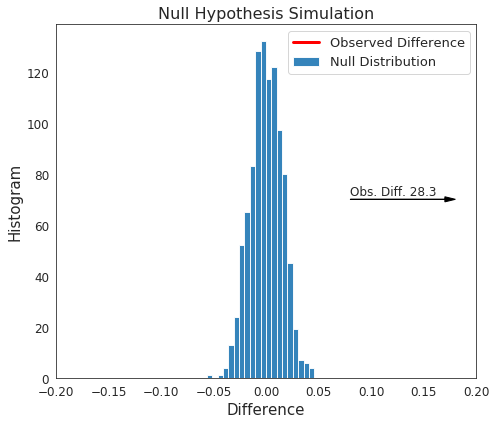

The p-value is 0.0
The observed difference is 28.3


In [482]:
#plot the null hypothesis simulation results
fig, ax = plt.subplots(figsize=(7, 6))
ax.hist(bootstrap_reps_diff, alpha=0.9, bins=20)
ax.axvline(obs_diff, color='red', linewidth=3)
ax.set_xlabel('Difference')
ax.set_ylabel('Histogram')
ax.set_xlim(-0.2, 0.2)
ax.legend(labels=('Observed Difference', 'Null Distribution'), fontsize=13)
ax.arrow(0.08, 70, 0.09, 0, color='k', head_width=2, head_length=0.01)
ax.text(x=0.08, y=71.5, s=('Obs. Diff. {0:.1f}'.format(obs_diff)), fontsize=12)
ax.set_title('Null Hypothesis Simulation', size=16)
plt.savefig('/home/delloro/Springboard/Assignments/Capstone_2/figures/hyp_test.png')
plt.tight_layout()
plt.show()

print('The p-value is', round(bs_p_value))
print('The observed difference is', round(obs_diff, 1))

The hypothesis test results suggest that the null hypothesis be rejected, and that there is a statistically significant difference between 'plane' and 'not-plane' classes.

The pixel intensities will be input as features for classification and prediction.